<a href="https://colab.research.google.com/github/daksha200/Projects/blob/testrepo/Noise_reduction_using_Convolutional_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will perform noise reduction similar to above figure on Fashion-MNIST dataset from Pytorch. We will add noise to the images for the network input and take targets as the original images.

In [1]:
# Import packages
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Load Fashion-MNIST data

We will use the Fashion-MNIST dataset from torchvision Pytorch and setup the train and test dataloaders in an usual manner.

In [4]:
batch_size_train = 128
batch_size_test = 128

# Images in torchvision datasets are PIL Images in range [0,1] so we need
# 'ToTensor' transform to convert them into tensors
train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 17830607.34it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 344944.96it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6124518.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9660974.05it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# Helper function to plot data
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  sample_idx = 0
  for i in range(1, cols * rows + 1):
      img, label = images[sample_idx], labels[sample_idx]
      sample_idx += 1
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")

  plt.show()

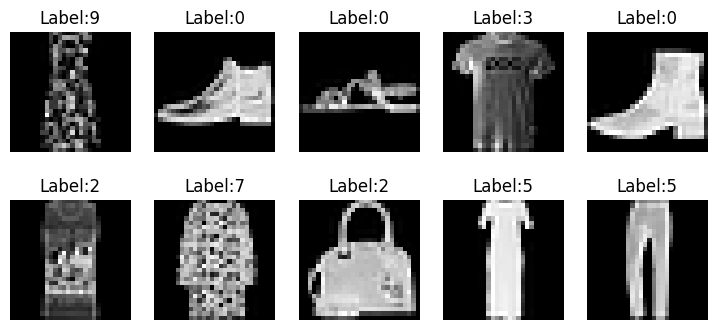

In [6]:
for i, sample in enumerate(train_loader):
  images, labels = sample
  plot_data(images, train_data.targets.numpy())
  break

Define the Autoencoder model

We stack up all our layers to perform encoding first with ReLU activation function. We also have the pooling layer after each convolutional layer. We thus obtain the latent space representation. Further, the decoding of the latent space representation takes place. Again all the ConvTranspose2d() go through the ReLU activation function. ConvTranspose2d() implements the reverse operation of Conv2d layer i.e reverse of convolution operation. The final decoding layer is coupled with the sigmoid activation function.



In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)

        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation

         # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x

In [8]:
# Build the model object and put on the device
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Define Loss function

In [9]:
# Reconstuction loss (to compare original and reconstructed image)
loss_func = nn.MSELoss() # mean squared error loss

Define optimizer

In [10]:
# Basic SGD optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Train the model

Function to add Gaussian noise to the image

In [11]:
def add_noise(image, mean=0., std=0.2):
  return image + torch.randn(image.size()) * std + mean

Helper function for training/testing

In [12]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, _) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Add noise to image
      noisy_images = add_noise(images)


      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass with noisy data
      output = model(noisy_images)

      # Calculate loss with reconstructed images and original images
      loss = loss_func(output, images)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      epoch_loss = running_loss / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    print ('Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

  return train_losses


In [13]:
def test(model, test_loader):
  # Eval mode
  model.eval()
  test_acc = 0
  correct = 0
  for i, (images, labels) in enumerate(test_loader):
    # Deactivate autograd engine (don't compute grads since we're not training)
    with torch.no_grad():
      # Add noise to image
      noisy_images = add_noise(images)
      # Put data on devices
      images = images.to(device)
      noisy_images = noisy_images.to(device)

      # Forward pass
      output = model(noisy_images)
    break

  # Plot the noisy and corresponding reconstructed images
  plot_data(noisy_images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)
  plot_data(images.data.cpu().numpy(), labels.numpy(), test_loader.dataset.classes)

Start training

In [14]:
num_epochs = 5  # iterations
train_losses = train(num_epochs, model, train_loader, loss_func, optimizer)

Epoch 1/5, Loss: 0.0011
Epoch 2/5, Loss: 0.0010
Epoch 3/5, Loss: 0.0010
Epoch 4/5, Loss: 0.0010
Epoch 5/5, Loss: 0.0010


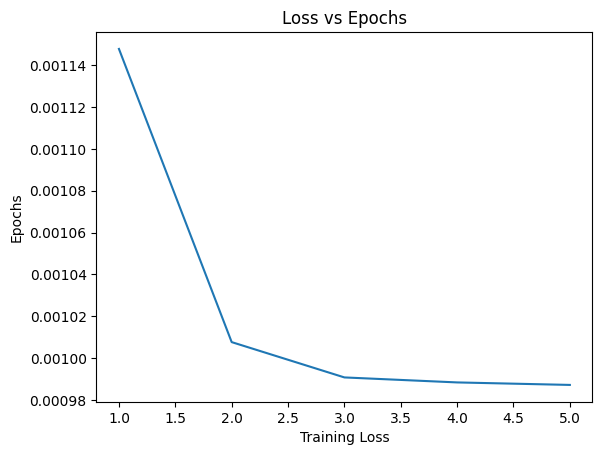

In [15]:
plt.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training Loss')
plt.ylabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

Evaluate the model

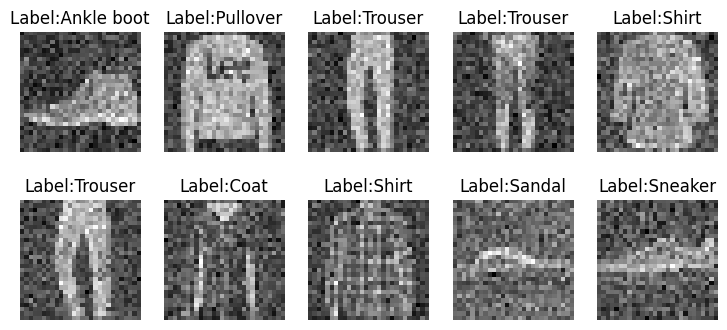

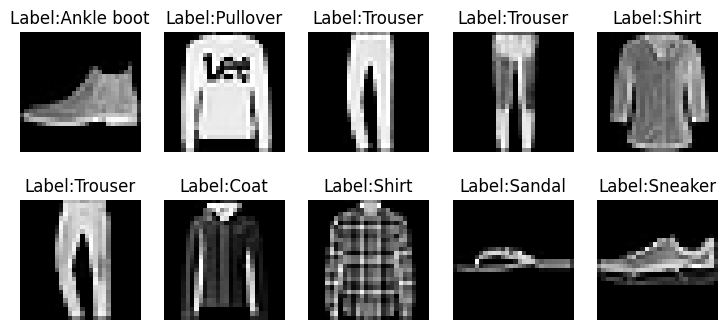

In [16]:
# Evaluate the model on testing data and plot predictions
test(model, test_loader)

As you can observe, the network learns to remove noise from the images and produce a cleaner version. Now, the encoder of the network which has already learnt important features from the dataset can be further used to perform classification.